In [1]:
import matplotlib.pyplot as plt
import numpy as np
import joblib as jb
import helper_functions as hlf
# from tensorflow import keras


# from keras.models import Model, load_model
# from keras.layers import Dense, Input, Conv2D, MaxPool2D, UpSampling2D
# from keras import backend as k

%matplotlib inline

Using TensorFlow backend.


In [ ]:
# load preprocessed dragonfly images
trainpath = r'D:\Linnaeus_models\dragon\train\dragon_train.npy'
testpath = r'D:\Linnaeus_models\dragon\test\dragon_test.npy'
dragons = np.concatenate((np.load(trainpath), np.load(testpath)), axis=0)
print(f'Number of images: {len(dragons)}')

##  Auto Encoding With CNN
   * Test image denoising abilities on the images

In [ ]:
# separate into training set and validation set and reshape to fit the NN
x_train = dragons[0:17000] 
x_val = dragons[17000:]

In [ ]:
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)

In [2]:
model = hlf.create_unsupervised_model()
model.summary()







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 48)      480       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 48)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      13856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
____

In [ ]:
train_history = model.fit(x_train, x_train, epochs=10, batch_size=100, 
                          validation_data=(x_val, x_val))
# save model
model_path =  r'D:\Linnaeus_models\dragon_reconstruction_v1.pkl'
jb.dump(loaded_model, model_path)

### Reload unsupervised model to continue training

In [ ]:
# load the model
loaded_model = jb.load(r'D:\Linnaeus_models\dragon_reconstruction_v3.pkl')

In [ ]:
# continue training the unsupervised model
train_history = loaded_model.fit(x_train, x_train, epochs=16, batch_size=100, 
                                 validation_data=(x_val, x_val))

# save model and weights
loaded_model.save_weights(r'D:\Linnaeus_models\dragon_reconstruction_v4_weights')
model_path =  r'D:\Linnaeus_models\dragon_reconstruction_v4.pkl'
jb.dump(loaded_model, model_path)

In [ ]:
# preds = loaded_model.predict(x_val)
jb.dump(preds, './unsupervised_val_images.pkl')

In [ ]:
preds = jb.load('./unsupervised_val_images.pkl')

In [ ]:
reverted_x = np.squeeze(x_val, axis=-1)

In [ ]:
plt.imshow(reverted_x[2].reshape(256, 256), cmap='gray')

In [ ]:
plt.imshow(x_val[10].reshape(256, 256), cmap='gray')

In [ ]:
plt.imshow(preds[10].reshape(256, 256), cmap='gray')

In [ ]:
# save model
model_path =  r'D:\Linnaeus_models\dragon_reconstruction_v3.pkl'
jb.dump(loaded_model, model_path)

In [ ]:
# past models

In [4]:
model_name =  r'D:\Linnaeus_models\dragon_reconstruction_v1.pkl'
new_model = jb.load(model_name)

In [5]:
# import keras
# import pydot
# from keras.utils import plot_model
# keras.utils.vis_utils.pydot = pydot
hlf.plot_model(new_model, to_file='model.png')

In [ ]:
from keras.utils.vis_utils import model_to_dot

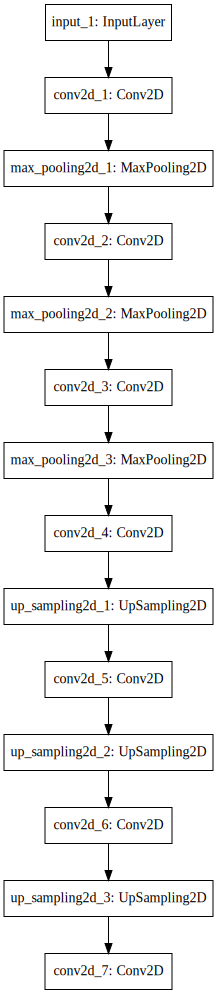

In [8]:
from IPython.display import SVG
SVG(hlf.model_to_dot(new_model).create(prog='dot', format='svg'))